In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost with one-hot NAICS Clusters (NN Embed)
XGBoost model, one hot encoded values from k means clustering

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

##### Get loans data, append clusters

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
sba_loans.filter(like='NAICS').columns

Index(['NAICS', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc', 'NAICS_num',
       'menc_NAICS', 'cenc_NAICS', 'menc_grp_NAICS'],
      dtype='object')

In [8]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('60_DATA_embeddings_tsne_naics.parquet'))

In [9]:
clus_cols = [c for c in embed_df if c.startswith('NC__')]
len(clus_cols)

9

In [10]:
sba_loans = sba_loans.drop(columns = clus_cols, errors='ignore') \
    .merge(embed_df[clus_cols + ['NAICS_orig']].rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

In [11]:
sba_loans[clus_cols].describe()

,NC__0,NC__1,NC__2,NC__3,NC__4,NC__5,NC__6,NC__7,NC__8
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.103517,0.273533,0.158478,0.100052,0.070778,0.006148,0.166281,0.084734,0.036478
std,0.304633,0.445772,0.365189,0.300070,0.256454,0.078165,0.372333,0.278486,0.187477
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [13]:
train_df.shape

(425594, 59)

#### Set the predictor features.  Include one-hot NAICS

In [14]:
predictor_features = setup.predictor_features + clus_cols
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'NC__0', 'NC__1', 'NC__2', 'NC__3', 'NC__4', 'NC__5', 'NC__6', 'NC__7', 'NC__8']


In [15]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,NC__0,NC__1,NC__2,NC__3,NC__4,NC__5,NC__6,NC__7,NC__8,target
NoEmp,1.000000,0.052510,-0.009243,0.093125,-0.038672,0.002058,0.006517,0.008876,-0.013239,-0.012868,0.007835,-0.000568,0.005778,0.010324,0.009169,-0.009977,-0.027838
CreateJob,0.052510,1.000000,-0.046967,0.101755,0.028831,0.009019,0.036918,0.004230,-0.019744,0.010005,-0.005271,-0.010181,-0.003604,0.026625,-0.000302,-0.005439,-0.009540
LowDoc,-0.009243,-0.046967,1.000000,-0.133731,0.154037,-0.119292,0.039258,-0.001184,0.020690,-0.005917,0.020548,-0.001311,0.000309,-0.011851,-0.006699,-0.034927,-0.076836
DisbursementGross,0.093125,0.101755,-0.133731,1.000000,-0.067410,-0.006023,0.082087,0.059625,-0.085585,-0.076344,-0.002471,0.071413,0.032909,-0.009928,0.124749,-0.040325,-0.122857
new_business,-0.038672,0.028831,0.154037,-0.067410,1.000000,-0.046626,0.136142,-0.007905,0.008287,0.067354,-0.057616,-0.005447,-0.010621,0.017034,-0.027126,-0.008557,0.014277
urban_flag,0.002058,0.009019,-0.119292,-0.006023,-0.046626,1.000000,-0.004093,0.004208,-0.007579,0.008734,0.009056,-0.009479,-0.032083,0.015557,-0.045811,0.033772,0.054391
franchise_flag,0.006517,0.036918,0.039258,0.082087,0.136142,-0.004093,1.000000,-0.048539,-0.013928,0.153065,-0.044312,-0.053768,-0.017604,0.014234,0.001093,-0.021665,-0.011047
NC__0,0.008876,0.004230,-0.001184,0.059625,-0.007905,0.004208,-0.048539,1.000000,-0.221997,-0.126214,-0.119748,-0.098846,-0.028167,-0.161017,-0.109012,-0.069396,-0.053390
NC__1,-0.013239,-0.019744,0.020690,-0.085585,0.008287,-0.007579,-0.013928,-0.221997,1.000000,-0.229758,-0.217986,-0.179938,-0.051276,-0.293112,-0.198443,-0.126327,0.030942
NC__2,-0.012868,0.010005,-0.005917,-0.076344,0.067354,0.008734,0.153065,-0.126214,-0.229758,1.000000,-0.123934,-0.102302,-0.029152,-0.166646,-0.112823,-0.071822,0.095261


In [16]:
with open(Path(setup.temp_path).joinpath('61_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [17]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [18]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [19]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators)

In [20]:
xgb_model = xgb_model.set_params(**xgb_params)

In [21]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.49893	validation_1-logloss:0.50183
[1]	validation_0-logloss:0.49187	validation_1-logloss:0.49487
[2]	validation_0-logloss:0.48585	validation_1-logloss:0.48891
[3]	validation_0-logloss:0.48080	validation_1-logloss:0.48387
[4]	validation_0-logloss:0.47634	validation_1-logloss:0.47947
[5]	validation_0-logloss:0.47252	validation_1-logloss:0.47574
[6]	validation_0-logloss:0.46933	validation_1-logloss:0.47258
[7]	validation_0-logloss:0.46662	validation_1-logloss:0.46997
[8]	validation_0-logloss:0.46396	validation_1-logloss:0.46743
[9]	validation_0-logloss:0.46162	validation_1-logloss:0.46523
[10]	validation_0-logloss:0.45963	validation_1-logloss:0.46333
[11]	validation_0-logloss:0.45806	validation_1-logloss:0.46181
[12]	validation_0-logloss:0.45659	validation_1-logloss:0.46043
[13]	validation_0-logloss:0.45543	validation_1-logloss:0.45932
[14]	validation_0-logloss:0.45424	validation_1-logloss:0.45822
[15]	validation_0-logloss:0.45317	validation_1-logloss:0.45725
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

##### Save the model

In [22]:
xgb_model.save_model(Path(setup.temp_path).joinpath('61_MODEL_xgboost.json'))

In [23]:
with open(Path(setup.temp_path).joinpath('61_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [24]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [25]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.187219,0.115332,0.016529,0.667458,0.173154
1,0.284144,0.104707,0.016605,0.692865,0.294252


## Decision Threshold
Max f1, on training data

In [26]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [27]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [28]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('61_REPORT_thresh_tune.csv'), index=False)

In [29]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.453659
11,0.22,0.452055


##### Apply decision threshold
All datasets

In [30]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [31]:
pred_df['predict_bin'].value_counts()

predict_bin
0    389235
1    298846
Name: count, dtype: int64

In [32]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('61_DATA_combined_predictions.parquet'))

## Metrics

In [33]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('61_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.624093,0.437913,0.312715,0.730290,0.365933,0.719377,NaN
1,train,0.656363,0.453659,0.334983,0.702558,0.385785,0.735210,NaN
2,val,0.655564,0.454563,0.336928,0.698402,0.378508,0.729766,NaN
0,test,0.654390,0.449398,0.332662,0.692355,0.381205,0.728506,0.0
1,test,0.530326,0.409879,0.269473,0.855771,0.345317,0.716564,1.0


## Lift
Test data

In [34]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

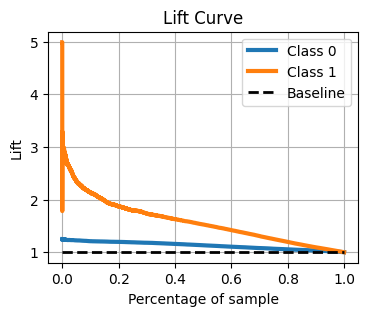

In [35]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('61_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [36]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [37]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('61_REPORT_importance_gain.csv'), index=True)

In [38]:
feat_impgain.head()

,importance
urban_flag,747.310242
NC__8,146.519424
LowDoc,117.761818
NC__4,115.819450
NC__7,100.523529


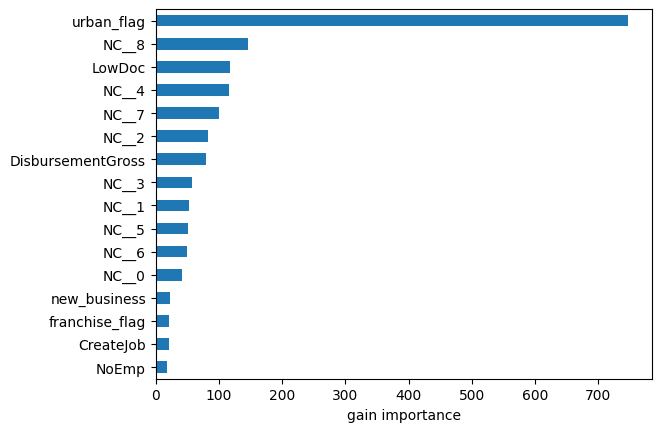

In [39]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('61_PLOT_importance_gain.png'))

##### Permutation Importance

In [40]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [41]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [42]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.072805,0.072805
5,urban_flag,0.043780,0.043780
1,CreateJob,0.022117,0.022117
15,NC__8,0.019343,0.019343
2,LowDoc,0.013431,0.013431


In [43]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('61_DATA_importance_perturb.csv'),
            index=False)

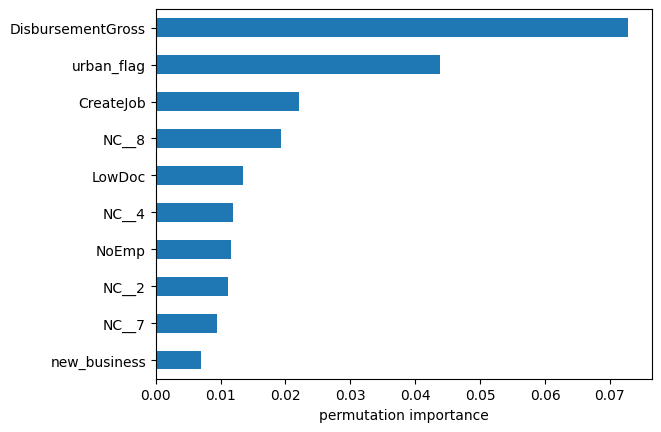

In [44]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('61_PLOT_importance_perturb.png'))

## PDP Plot - One Hot

In [45]:
naics_features = list(train_df.filter(like='NC_').columns)

In [46]:
plt.close()

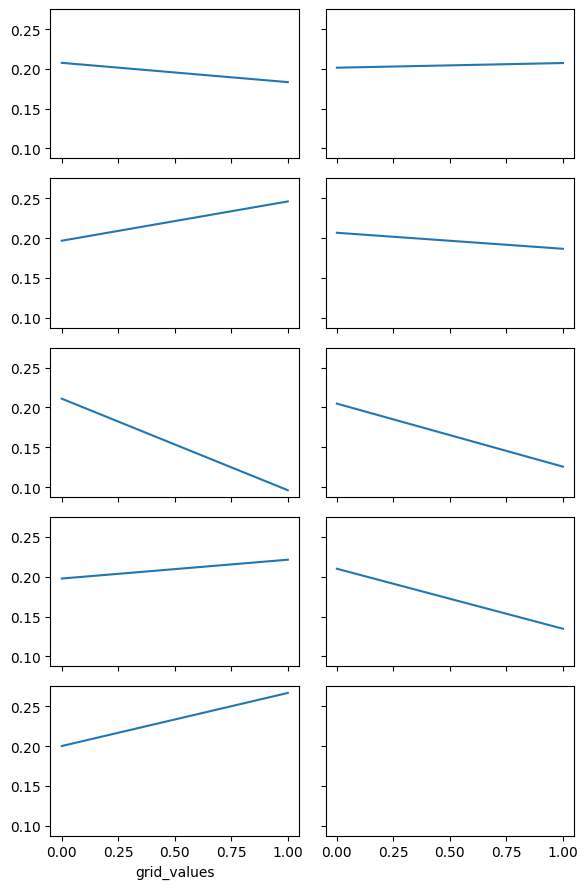

In [47]:
fig, ax = plt.subplots(int(np.ceil(len(naics_features)/2)), 2, sharex=True, sharey=True, figsize=(6, 9))
for i in range(len(naics_features)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    results = partial_dependence(xgb_model, train_df[predictor_features], 
                                 [naics_features[i]])
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('61_PLOT_pdp_naics_onehot.png'),
               bbox_inches='tight')
plt.show()